In [23]:
import scipy as sp
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1
primaryImage = np.transpose(primaryImage)

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with primary porosity

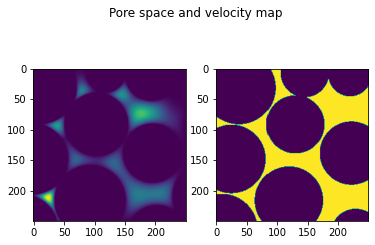

In [5]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])




In [3]:
# testIM = primaryImage.astype(bool)
# testIM = testIM[:,:,slice]
# skelIM = ski.morphology.skeletonize(testIM)
#
# plt.imshow(skelIM)

# Extract pore network information

In [6]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 17.32it/s]


In [5]:
regions = snowFiltPrimary.regions

In [6]:
ps.io.to_vtk(regions,'snowRegions')

# Plot velocity histogram from simulation

Text(0.5, 0, 'All pore velocities')

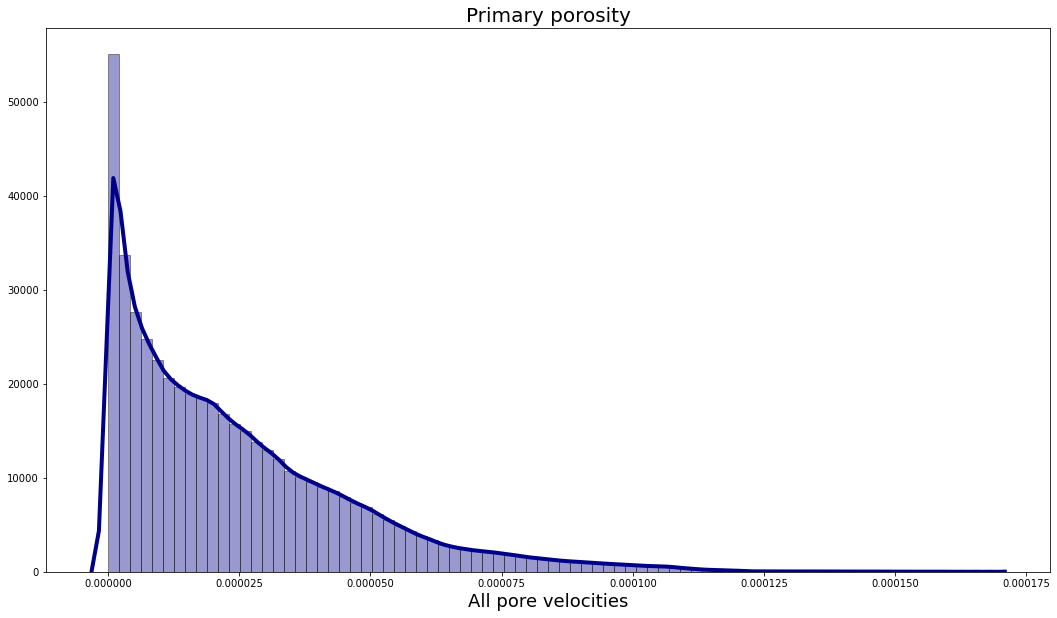

In [7]:
allPrimaryVelocities = np.ndarray.flatten(velDataNormPrimary)

filtIndex = allPrimaryVelocities > 0
trueZeroIndex = allPrimaryVelocities == 0

filtPrimaryVelocities = allPrimaryVelocities[filtIndex]
filtZeroPrimaryVelocities = allPrimaryVelocities[trueZeroIndex]

fig, axes = plt.subplots(1, 1, figsize=(18, 10))
sns.distplot(filtPrimaryVelocities, ax=axes, hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes.set_title('Primary porosity', fontsize=20)
axes.set_xlabel('All pore velocities', fontsize=18)


# Skeleton implementation


In [8]:
primaryRegionData = ps.metrics.regionprops_3D(snowFiltPrimary.regions) #Gives properties for each region
primaryRegionData.append([])

primaryRegions = snowFiltPrimary.regions

100%|██████████| 93/93 [00:39<00:00,  2.37it/s]


------------------------------------------------------------
Calculating regionprops


Find skeleton for primary image and collect info

In [9]:
cubeSize = len(primaryImage)
primarySkelImage = np.zeros(primaryImage.shape)
edgeImage = np.zeros(primaryImage.shape)
visit = np.zeros(len(primaryRegionData))
primaryRegionImage = np.zeros(primaryImage.shape)
primaryPoreDiamImage = np.zeros(primaryImage.shape)
regionStepImage = np.zeros(primaryImage.shape)
skeletonDone = np.zeros(len(primaryRegionData))

poreDiamForMedian = []
for a in tqdm.tqdm(range(0, cubeSize), 'Main loop'):
    for b in range(cubeSize):
        for c in range(cubeSize):
            regionLabel = snowFiltPrimary.regions[a,b,c]
            if regionLabel != 0: # Don't want grains to be counted

                #TODO: Fix this region label index, this is causing problems with computing the skeleton of the grains

                #############
                regionLabel = regionLabel - 1 # Adjusting index to work with region props command
                #############

                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    #index = snowFiltPrimary.regions[a,b,c]
                    regionInd = snowFiltPrimary.regions == regionLabel
                    # regionBorder = primaryRegionData[regionLabel].slice
                    # We don't want to use regionBorder or the slice feature! This gives a box outline
                    # not the actual pore!!!
                    # primarySkelImage[primaryRegions == regionLabel] = primaryRegionData[regionLabel].skeleton
                    #edgeImage[snowFiltPrimary.regions[a,b,c] == regionLabel] = regionData[regionLabel].border

                    primaryRegionImage[primaryRegions == regionLabel] =  regionLabel

                    if skeletonDone[regionLabel] == 0:
                        if regionLabel != 0:
                            regionStepImage[primaryRegions == regionLabel] = 1
                            regionSkeleton = ski.morphology.skeletonize(regionStepImage)
                            #print('Saving skeleton for ', regionLabel)
                            # Save skeleton for this region
                            primarySkelImage[primaryRegions == regionLabel] = regionSkeleton[primaryRegions == regionLabel]

                            # Reset for next iteration
                            regionStepImage[primaryRegions == regionLabel] = 0
                            skeletonDone[regionLabel] = 1

                    poreDiam = poreInfoPrimary['pore.diameter'][regionLabel]
                    poreDiamForMedian = np.append(poreDiamForMedian, poreInfoPrimary['pore.diameter'][regionLabel])
                    primaryPoreDiamImage[primaryRegions == regionLabel] = poreDiam

Main loop: 100%|██████████| 250/250 [02:36<00:00,  1.60it/s]


In [10]:
ps.io.to_vtk(primarySkelImage,'primarySkeleton')
primaryImageOut = primaryImage
primaryImageOut[primaryImage == 1] = 255
ps.io.to_vtk(primaryImageOut,'primaryImage')

In [11]:
testRegion = 6
oneRegionImage = np.zeros(primaryImage.shape)
testRegionBorder = primaryRegionData[testRegion].slice
oneRegionImage[primaryRegions == testRegion] = 255

ps.io.to_vtk(oneRegionImage,'oneRegionImage')

# Skeletonize one pore region using python image library algorithm

In [12]:
testRegionNum = 44
oneRegionImage = np.zeros(primaryImage.shape)
oneSkeletonImage = np.zeros(primaryImage.shape)

testRegion = primaryRegionData[testRegionNum]

oneRegionImage[primaryRegions == testRegionNum] = 1
testSkel = ski.morphology.skeletonize(oneRegionImage)
oneSkeletonImage[testSkel > 0] = 200

oneRegionImage[oneRegionImage == 1] = 255
ps.io.to_vtk(oneRegionImage,'oneRegionImage')
ps.io.to_vtk(oneSkeletonImage,'oneSkeletonImage')

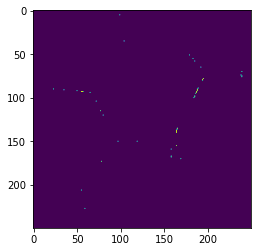

In [13]:
plt.imshow(primarySkelImage[:,:,40])

# ps.io.to_vtk(primarySkelImage,'PS_skeletonImage')
#primaryImage[primaryImage == 1] = 255 # Make red/blue distinction
#ps.io.to_vtk(primaryImage,'primaryImage')


# Now plot velocitites on skeleton and extract information

In [10]:
primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []
primaryPoreRegionSkeleton = []

for a in range(0,cubeSize):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if primarySkelImage[a,b,c] != 0:
                primaryVelocitiesSkeleton = np.append(primaryVelocitiesSkeleton,velDataNormPrimary[a,b,c])
                primaryPoreDiamSkeleton = np.append(primaryPoreDiamSkeleton, primaryPoreDiamImage[a,b,c])
                primaryPoreRegionSkeleton = np.append(primaryPoreRegionSkeleton, primaryRegionImage[a,b,c])

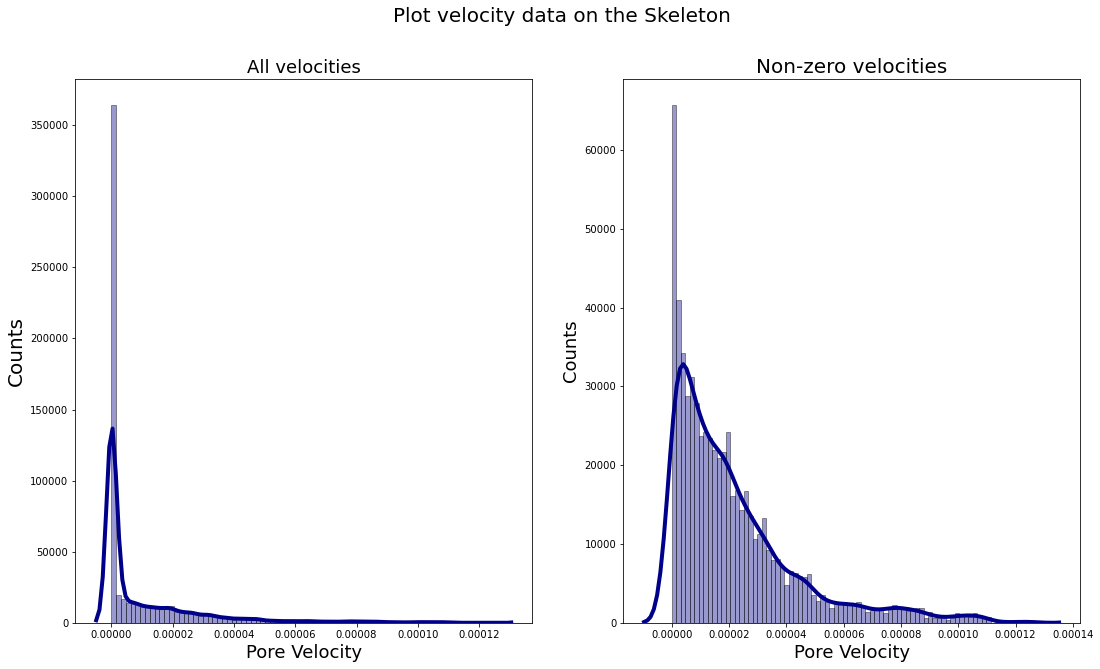

In [11]:
# The zeros seen here are truely no flow I think, they aren't pore walls and this is after the flow simulation, so
# even though the initial lattice state is v = 0, these are still zero

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Plot velocity data on the Skeleton', fontsize=20)

sns.distplot(primaryVelocitiesSkeleton, ax=axes[0], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('All velocities', fontsize=18)
axes[0].set_xlabel('Pore Velocity', fontsize=18)
axes[0].set_ylabel('Counts', fontsize=20)

sns.distplot(primaryVelocitiesSkeleton[primaryVelocitiesSkeleton != 0], ax=axes[1], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Non-zero velocities', fontsize=20)
axes[1].set_xlabel('Pore Velocity', fontsize=18)
axes[1].set_ylabel('Counts', fontsize=18)

fig.savefig('poreVelHistograms.png')

# Plot pore velocities with pore diameters



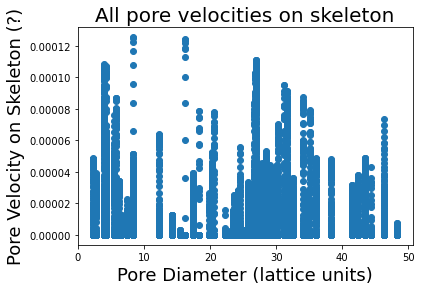

In [12]:
plt.scatter(primaryPoreDiamSkeleton, primaryVelocitiesSkeleton)
plt.xlabel('Pore Diameter (lattice units)', fontsize=18)
plt.ylabel('Pore Velocity on Skeleton (?)', fontsize=18)
plt.title('All pore velocities on skeleton', fontsize=20)

fig.savefig('allPoreVelocities.png')


Try taking median velocity

In [13]:
medianPoreVelocity =  []
meanPoreVelocity =  []
skeletonPoreDiam = []
skeletonPoreRegion = []
poreRegions, indices = np.unique(primaryPoreRegionSkeleton, return_index='True')

for a in range(0, len(poreRegions)):
    currentRegion = poreRegions[a]
    poreRegionIndex = primaryPoreRegionSkeleton[indices[a]]

    skeletonPoreVel = primaryVelocitiesSkeleton[primaryPoreRegionSkeleton == poreRegionIndex]

    meanPoreVelocity = np.append(meanPoreVelocity, np.mean(skeletonPoreVel) )
    medianPoreVelocity = np.append(medianPoreVelocity, np.median(skeletonPoreVel) )
    skeletonPoreDiam = np.append(skeletonPoreDiam, poreDiamForMedian[int(poreRegionIndex)] )
    skeletonPoreRegion = np.append(skeletonPoreRegion, int(poreRegionIndex))

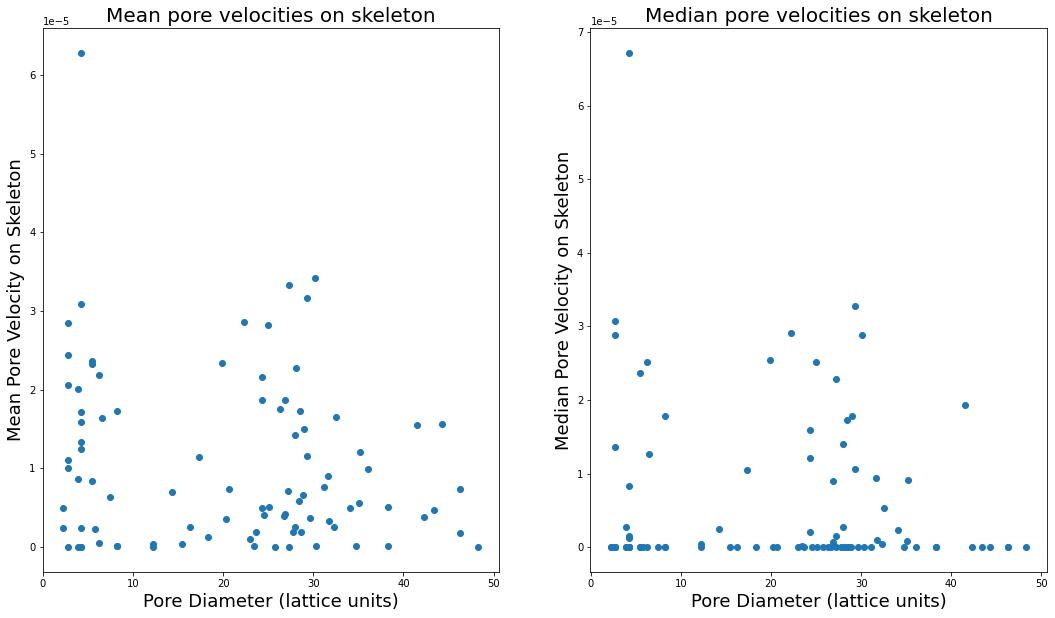

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].scatter(skeletonPoreDiam, meanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)

axes[1].scatter(skeletonPoreDiam, medianPoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('Median pore velocities on skeleton', fontsize=20)

fig.savefig('poreVelAveraging.png')

Separate pores with low velocity


In [15]:
# Best choice for this is diffusion related but a velocity?
noFlowVelCutoff = 0.5 * 10 ** float(-5)
print(noFlowVelCutoff)

5e-06


In [21]:
noFlowRegions = skeletonPoreRegion[meanPoreVelocity < noFlowVelCutoff]
noFlowImage = np.zeros(primaryImage.shape)
flowImage = np.copy(primaryImage)

for a in range(0, len(noFlowRegions)):
    regionInd = noFlowRegions[a]
    print('This is a no flow region:', regionInd)
    noFlowImage[primaryRegionImage == regionInd] =  1
    flowImage[primaryRegionImage == regionInd] = 0



This is a no flow region: 5.0
This is a no flow region: 7.0
This is a no flow region: 8.0
This is a no flow region: 10.0
This is a no flow region: 13.0
This is a no flow region: 14.0
This is a no flow region: 20.0
This is a no flow region: 24.0
This is a no flow region: 26.0
This is a no flow region: 27.0
This is a no flow region: 34.0
This is a no flow region: 35.0
This is a no flow region: 37.0
This is a no flow region: 38.0
This is a no flow region: 40.0
This is a no flow region: 42.0
This is a no flow region: 44.0
This is a no flow region: 45.0
This is a no flow region: 50.0
This is a no flow region: 52.0
This is a no flow region: 54.0
This is a no flow region: 56.0
This is a no flow region: 57.0
This is a no flow region: 62.0
This is a no flow region: 63.0
This is a no flow region: 65.0
This is a no flow region: 69.0
This is a no flow region: 70.0
This is a no flow region: 71.0
This is a no flow region: 77.0
This is a no flow region: 79.0
This is a no flow region: 80.0
This is a n

In [17]:
# Rescale no Flow data
velImage = velDataNormPrimary
velImage = velImage / np.max(velImage)
velImage = velImage * 200
ps.io.to_vtk(velImage,'primaryVelocityImage')

noFlowOut = noFlowImage
noFlowOut[noFlowImage == 1] = 255
ps.io.to_vtk(noFlowImage,'noFlowPrimaryRegionImage')

In [76]:
print(np.max(velImage))
np.max(noFlowImage)

200.0


255.0

# Compute estimate of mobile porosity

Total Porosity

In [33]:

porosityCalc = ps.metrics.porosity(primaryImage)
print('Total porosity:')
print(porosityCalc)

Total porosity:
0.342324352


Estimate of mobile porosity

In [32]:
# Get grains
flippedImage = np.copy(primaryImage)
flippedImage[primaryImage == 1] = 0
flippedImage[primaryImage == 0] = 1

sumPorosity = np.sum(primaryImage)/(np.sum(flippedImage)+np.sum(primaryImage))
#print(sumPorosity)

mobileOnes = np.sum(flowImage)
total = np.sum(flippedImage) + np.sum(flowImage) + np.sum(noFlowImage)
mobilePorosity = mobileOnes/total
print('Mobile porosity estimate:')
print(mobilePorosity)

Mobile porosity estimate:
0.254978368
